In [10]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import sklearn
print(sklearn.__version__)

0.19.2
time: 1.49 ms (started: 2022-09-27 10:58:52 -07:00)


In [2]:
import os
from os.path import join
from astropy.io import fits
import numpy as np
from maskmoment import maskmoment
from dendroplot import run_dendro
from dendroplot.analysis import calc_phys_props, find_clusters, get_response_width
from dendroplot.plotting import colorcode, pltprops
from dendroplot.lte import lte, add_ltemass
%load_ext autotime

time: 1.2 s (started: 2022-09-27 10:49:47 -07:00)


/Users/tonywong/Library/Python/3.9/lib/python/site-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/Users/tonywong/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/Users/tonywong/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this

# Example for 30 Doradus Cycle 0 data from [Indebetouw et al. (2013)](https://doi.org/10.1088/0004-637X/774/1/73)

In [3]:
# Directory where input images reside.
indir = os.getcwd()

# Directories to write output files.
momdir = join(indir, 'mom')
if not os.path.isdir(momdir):
    os.makedirs(momdir)
    
ltedir = join(indir, 'lte')
if not os.path.isdir(ltedir):
    os.makedirs(ltedir)

dendir = join(indir, 'dendro')
if not os.path.isdir(dendir):
    os.makedirs(dendir)

time: 625 µs (started: 2022-09-27 10:49:49 -07:00)


## Generate moment maps from cubes via dilated masking
This is done using the external `maskmoment` package (https://github.com/tonywong94/maskmoment).

In [4]:
dolines = ['12', '13']

for line in dolines:
    maskmoment(img_fits=join(indir,'30dor_'+line+'CO21_2p5as.pbcor.fits.gz'), 
        rms_fits=join(indir,'30dor_'+line+'CO21_2p5as.rms.fits.gz'), outdir=momdir,
        snr_hi=4, snr_lo=2, minbeam=2, snr_hi_minch=2, nguard=[1,1], 
        outname='30dor_'+line+'CO21_2p5as_dil', output_snr_peak=True)


Output basename is: 30dor_12CO21_2p5as_dil
Image cube /Users/tonywong/Work/bin/py-package/dendroplot/example/30dor_12CO21_2p5as.pbcor.fits.gz:
 SpectralCube with shape=(120, 500, 500) and unit=K:
 n_x:    500  type_x: RA---SIN  unit_x: deg    range:    84.637472 deg:   84.754024 deg
 n_y:    500  type_y: DEC--SIN  unit_y: deg    range:   -69.097414 deg:  -69.055831 deg
 n_s:    120  type_s: VRAD      unit_s: m / s  range:   220155.466 m / s:  279696.656 m / s
Noise cube /Users/tonywong/Work/bin/py-package/dendroplot/example/30dor_12CO21_2p5as.rms.fits.gz:
 SpectralCube with shape=(120, 500, 500) and unit=K:
 n_x:    500  type_x: RA---SIN  unit_x: deg    range:    84.637472 deg:   84.754024 deg
 n_y:    500  type_y: DEC--SIN  unit_y: deg    range:   -69.097414 deg:  -69.055831 deg
 n_s:    120  type_s: VRAD      unit_s: m / s  range:   220155.466 m / s:  279696.656 m / s
SNR cube:
 SpectralCube with shape=(120, 500, 500):
 n_x:    500  type_x: RA---SIN  unit_x: deg    range:    84.6374

## Compute the LTE column density

In [5]:
tmin = 6  # Floor on Tex of 6 K

incube12 = join(indir, '30dor_12CO21_2p5as.pbcor.fits.gz')
incube13 = join(indir, '30dor_13CO21_2p5as.pbcor.fits.gz')
inrms12  = join(indir, '30dor_12CO21_2p5as.rms.fits.gz')
inrms13  = join(indir, '30dor_13CO21_2p5as.rms.fits.gz')
inmask12 = join(momdir,'30dor_12CO21_2p5as_dil.mask.fits.gz')
lte_names = [incube12, incube13, inrms12, inrms13, inmask12]

lte(files=lte_names, tfloor=tmin, outdir=ltedir, outname='30dor_2p5', tx_method='peak')


Reading /Users/tonywong/Work/bin/py-package/dendroplot/example/30dor_12CO21_2p5as.pbcor.fits.gz...
The 12CO rest frequency is 230.5380 GHz
min/max values of 12CO [K] are -3.50 and 51.48

Reading /Users/tonywong/Work/bin/py-package/dendroplot/example/30dor_12CO21_2p5as.rms.fits.gz...
min/max values of 12CO uncertainty are 0.112 and 0.561

Reading /Users/tonywong/Work/bin/py-package/dendroplot/example/mom/30dor_12CO21_2p5as_dil.mask.fits.gz...
Number of mask == 1 values: 1288518
Number of mask == 0 values: 28711482
Number of mask == NaN values: 0

Calculating Tex [excitation temperature]...
min/max values of Tex [K] are 6.00 K and 57.03 K
File /Users/tonywong/Work/bin/py-package/dendroplot/example/lte/30dor_2p5_peak_tex12.fits.gz successfully written

Reading /Users/tonywong/Work/bin/py-package/dendroplot/example/30dor_13CO21_2p5as.pbcor.fits.gz...
The 13CO rest frequency is 220.3987 GHz
min/max values of 13CO [K] are -1.64 and 19.58

Reading /Users/tonywong/Work/bin/py-package/dendropl

## Run the dendrogram analysis and calculate physical properties


Robustly estimated RMS: 0.109
Pixels per beam: 78.68
Loading pre-existing dendrogram
Generate a catalog of dendrogram structures
<Table length=166>
     name       dtype    unit 
-------------- ------- -------
          _idx   int64        
  area_ellipse float64 arcsec2
    area_exact float64 arcsec2
          flux float64      Jy
   major_sigma float64  arcsec
   minor_sigma float64  arcsec
position_angle float64     deg
        radius float64  arcsec
         v_cen float64     pix
         v_rms float64   m / s
         x_cen float64     pix
         y_cen float64     pix

Image the trunks
Finding descendants of trunk 1
Finding descendants of trunk 106
Image the leaves
- Creating affinity matrices
- Start spectral clustering
-- Rescaling volume matrix
-- Estimated scaling parameter: 210188.765025
-- Guessed number of clusters = 10
-- Number of k-means iteration: 1
-- Best cluster number found through SILHOUETTE (0.972916)= 12
SAVE_BRANCHES triggered, all isolated branches will be r

/Users/tonywong/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/spectral_embedding_.py:47: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  connected_nodes = np.zeros(n_node, dtype=np.bool)
/Users/tonywong/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/spectral_embedding_.py:48: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

Finding descendants of cluster 69
Finding descendants of cluster 80
Finding descendants of cluster 87
Finding descendants of cluster 93
Finding descendants of cluster 96
Finding descendants of cluster 106
Finding descendants of cluster 143
Finding descendants of cluster 148
Finding descendants of cluster 150
Identified 5589341 of 6875048 pixels as noise
Calculated Pearson r: 0.5400217534988706
Calculated k value: 0.19810856838201119
Effective response width [channels]: 1.6419369613010213

Pixels per beam: 78.69
Calculating property errors...
Calculating property errors for structure 1
Calculating property errors for structure 11
Calculating property errors for structure 21
Calculating property errors for structure 31
Calculating property errors for structure 41
Calculating property errors for structure 51
Calculating property errors for structure 61
Calculating property errors for structure 71
Calculating property errors for structure 81
Calculating property errors for structure 91
Cal

/Users/tonywong/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/spectral_embedding_.py:47: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  connected_nodes = np.zeros(n_node, dtype=np.bool)
/Users/tonywong/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/spectral_embedding_.py:48: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

Finding descendants of cluster 12
Finding descendants of cluster 17
Finding descendants of cluster 19
Finding descendants of cluster 20
Finding descendants of cluster 27
Finding descendants of cluster 40
Finding descendants of cluster 41
Identified 6564455 of 7002675 pixels as noise
Calculated Pearson r: 0.3996930292080354
Calculated k value: 0.1518699894833465
Effective response width [channels]: 1.4190773221293354

Pixels per beam: 78.69
Calculating property errors...
Calculating property errors for structure 1
Calculating property errors for structure 11
Calculating property errors for structure 21
Calculating property errors for structure 31
Calculating property errors for structure 41
Calculating property errors for structure 51
Calculating property errors for structure 61
Calculating property errors for structure 71
Calculating property errors for structure 81
The median fractional error in rad_pc is 0.1187
The median fractional error in rad_pc_dcon is 0.0495
The median fractiona

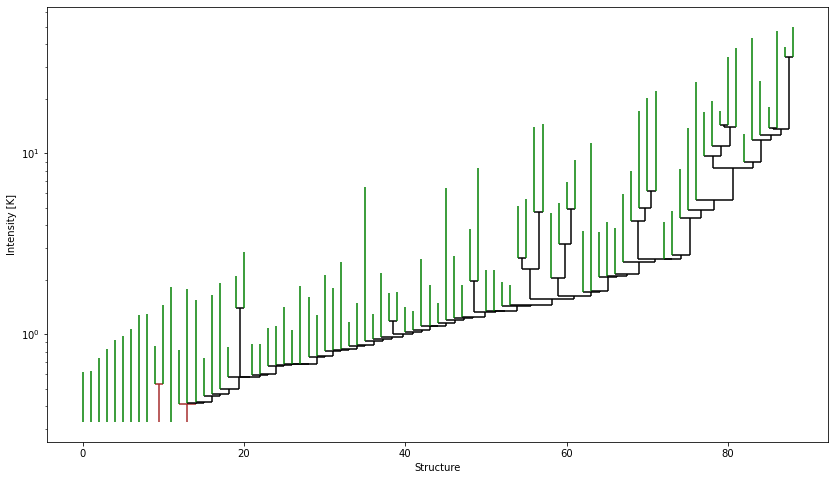

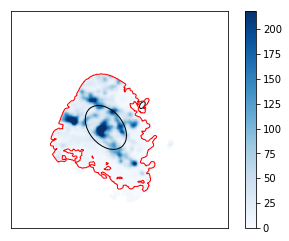

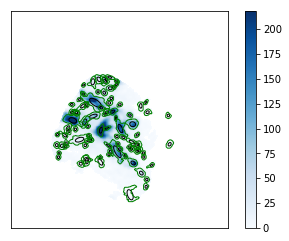

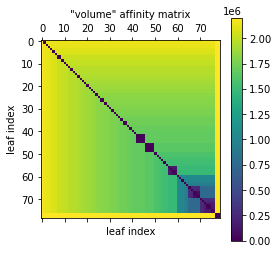

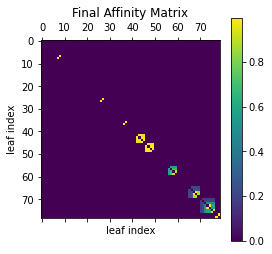

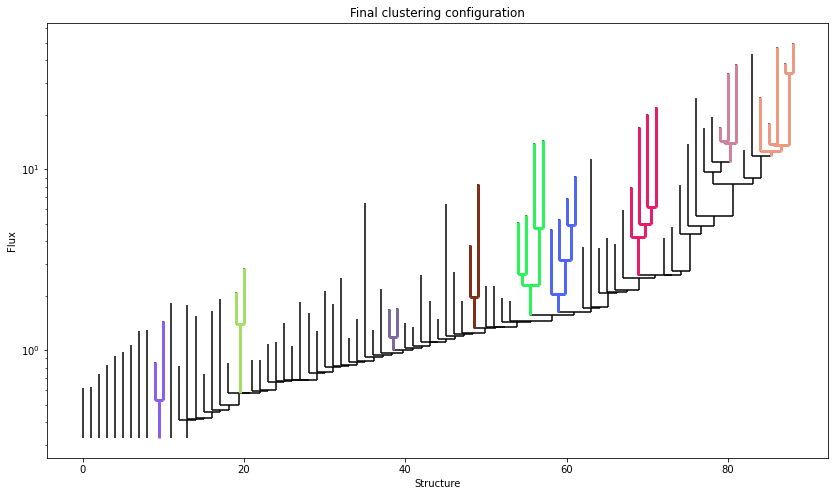

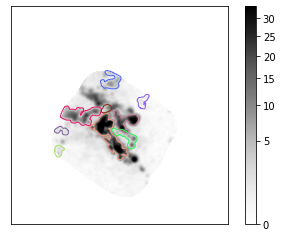

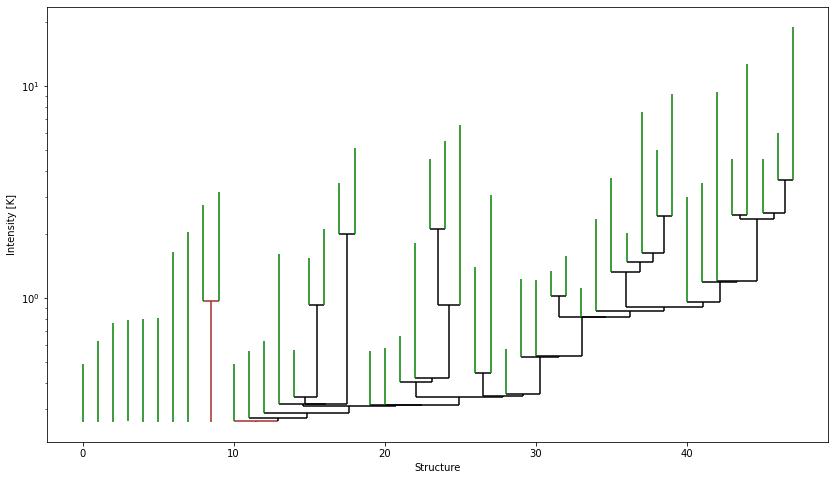

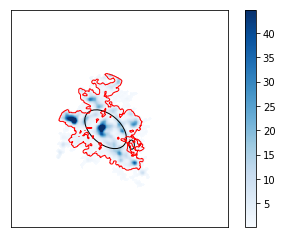

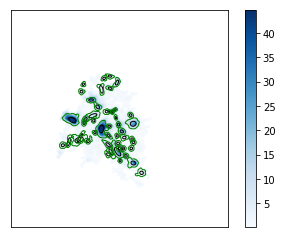

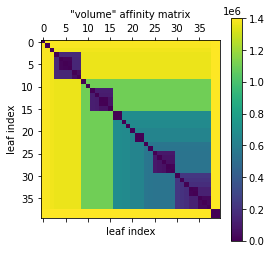

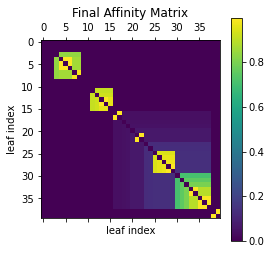

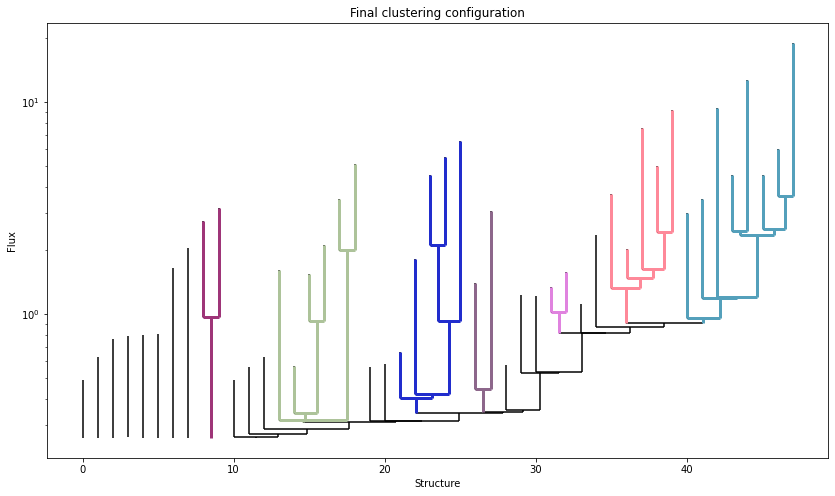

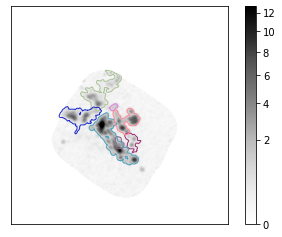

time: 6min 55s (started: 2022-09-27 10:50:11 -07:00)


In [6]:
redo = 'n'              # whether to regenerate dendrogram.hdf file
alphascale = 3          # scaling factor for XCO
criteria = ['volume']   # SCIMES criteria

old_dir = os.getcwd()
os.chdir(dendir)

pbcor = [join(indir, '30dor_12CO21_2p5as.pbcor.fits.gz')]
pbcor.append(join(indir, '30dor_13CO21_2p5as.pbcor.fits.gz'))
rmsfile = [join(indir, '30dor_12CO21_2p5as.rms.fits.gz')]
rmsfile.append(join(indir, '30dor_13CO21_2p5as.rms.fits.gz'))

for i, line in enumerate(['12', '13']):
    label = '30dor_'+line
    flatfile = join(indir, '30dor_'+line+'CO21_2p5as.image.fits.gz')
    # Produce a noise-flat cube for signal identification
    if not os.path.isfile(flatfile):
        cubearray, hdr = fits.getdata(pbcor[i], header=True)
        rmsarray = fits.getdata(rmsfile[i])
        rms_min = np.nanmin(rmsarray)
        print('Min value of',rmsfile,'is',rms_min)
        gainarray = rms_min/rmsarray
        flatarray = cubearray * np.broadcast_to(gainarray, cubearray.shape)
        fits.writeto(flatfile, flatarray.astype(np.float32), hdr, overwrite=True)
    mom0file = join(momdir, '30dor_'+line+'CO21_2p5as_dil.mom0.fits.gz')
    maskfile = join(momdir, '30dor_'+line+'CO21_2p5as_dil.mask.fits.gz')

    run_dendro(label=label, cubefile=flatfile, mom0file=mom0file, 
               redo=redo, verbose=False)
    find_clusters(criteria=criteria, label=label, cubefile=flatfile)
    resp = get_response_width(flatfile, maskname=maskfile, clip=0.5)
    calc_phys_props(label=label, cubefile=flatfile, efloor=0.05, dv_resp=resp,
        alphascale=alphascale, copbcor=pbcor[0], conoise=rmsfile[0])
    if os.path.isfile(join(ltedir, '30dor_2p5_peak_n13cube.fits.gz')):
        add_ltemass(n13cub=join(ltedir, '30dor_2p5_peak_n13cube.fits.gz'), 
            i12cub=pbcor[0], i13cub=pbcor[1], co13toh2=3.0e6, label=label,
            n13cub_uc=join(ltedir, '30dor_2p5_peak_n13cubeerr.fits.gz'))

os.chdir(old_dir)

## Color the dendros by mean velocity and velocity dispersion


Opening 30dor_12_full_catalog.txt
Working on leaves
Image leaves and clusters colored by properties

Working on v_cen
v0, v1: 220.30505081268805 272.0909747135351
Ticks: ['240', '260']
v_cen vmin and vmax: 220.30505081268805 272.0909747135351

Working on v_rms
v0, v1: 0.24870134164080418 3.1971529745276497
Ticks: ['1', '2', '3']
v_rms vmin and vmax: 0.24870134164080418 3.1971529745276497
Working on trunks
Image leaves and clusters colored by properties

Working on v_cen
v0, v1: 248.75253628946336 249.83665958011005
Ticks: ['249']
v_cen vmin and vmax: 248.75253628946336 249.83665958011005

Working on v_rms
v0, v1: 0.8491182799275424 4.836609474534936
Ticks: ['1', '2', '3', '4']
v_rms vmin and vmax: 0.8491182799275424 4.836609474534936
Working on clusters
Image leaves and clusters colored by properties

Working on v_cen
v0, v1: 242.10794202589128 260.32389131982933
Ticks: ['250', '260']
v_cen vmin and vmax: 242.10794202589128 260.32389131982933

Working on v_rms
v0, v1: 0.84911827992754

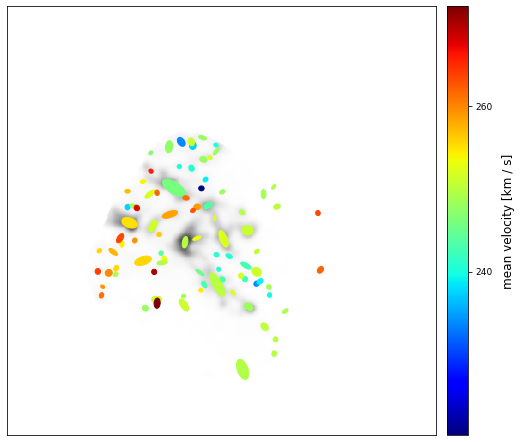

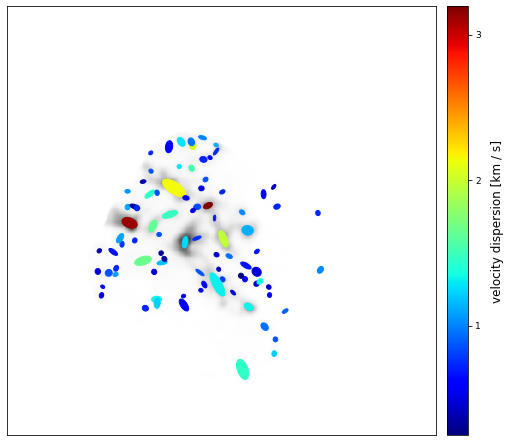

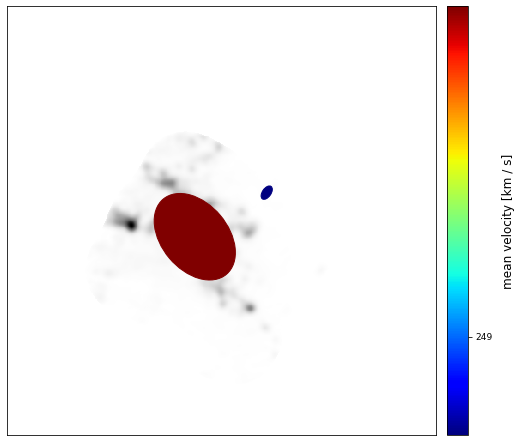

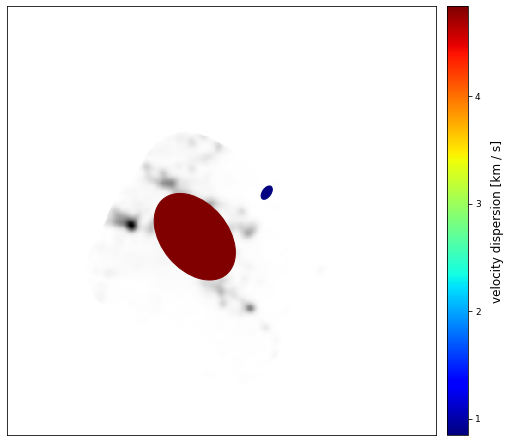

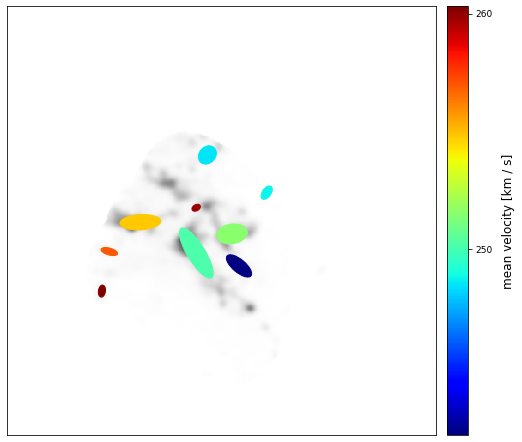

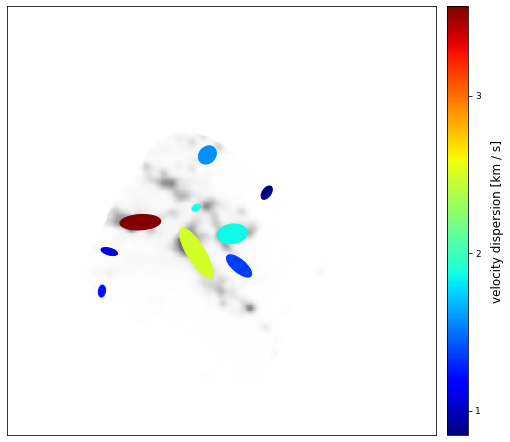

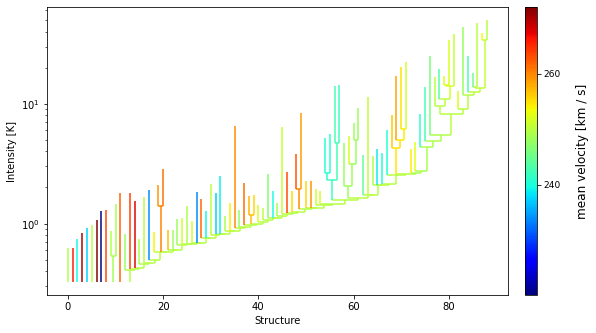

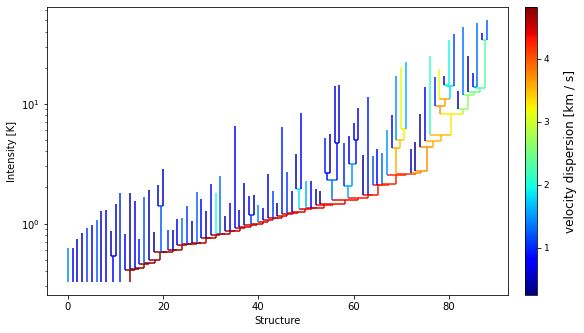

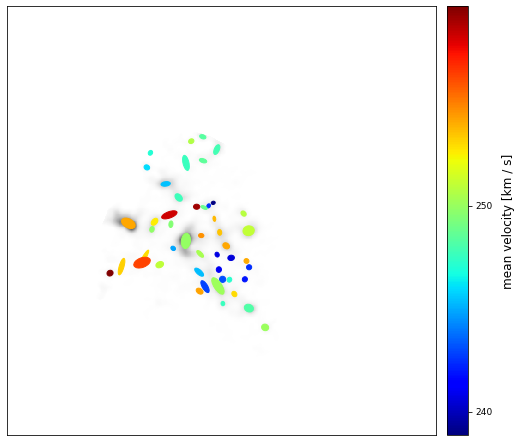

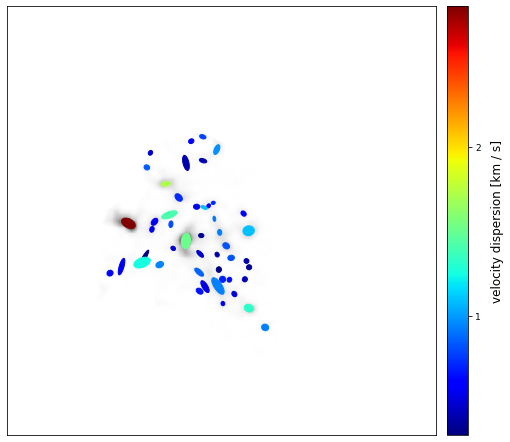

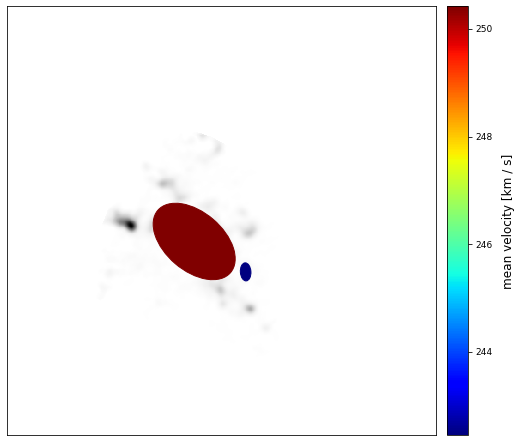

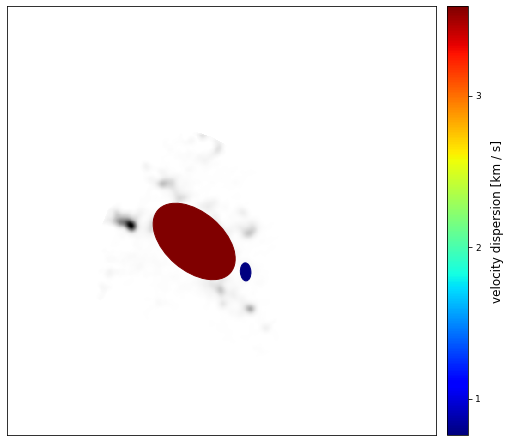

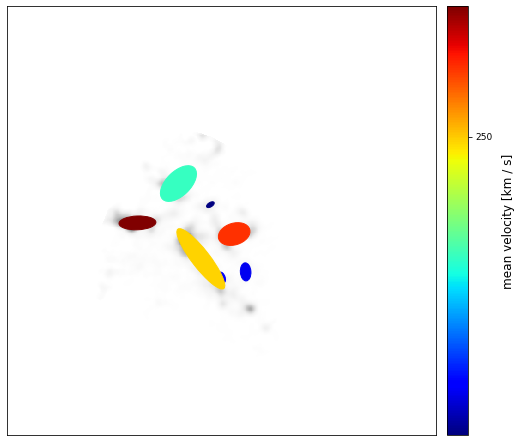

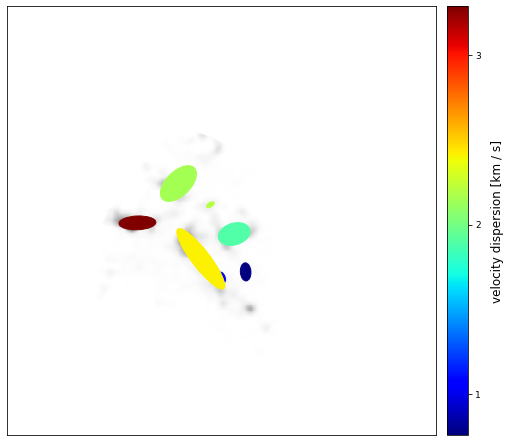

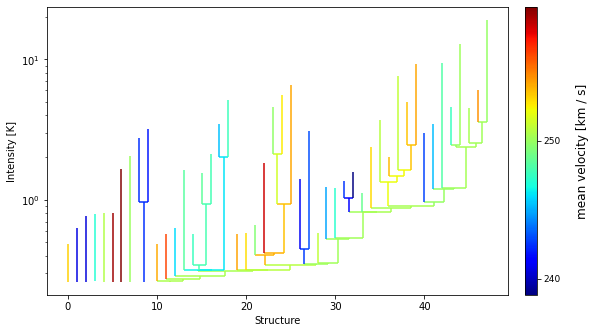

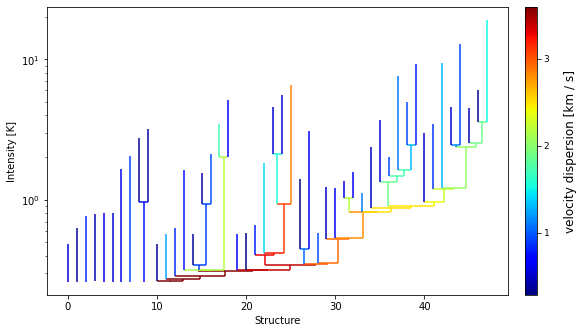

time: 9.66 s (started: 2022-09-27 10:57:06 -07:00)


In [7]:
old_dir = os.getcwd()
os.chdir(dendir)

for i, line in enumerate(['12', '13']):
    label = '30dor_'+line
    flatfile = join(indir, '30dor_'+line+'CO21_2p5as.image.fits.gz')
    mom0file = join(momdir, '30dor_'+line+'CO21_2p5as_dil.mom0.fits.gz')
    colorcode(label=label, cubefile=flatfile, mom0file=mom0file, types=['v_cen','v_rms'])

os.chdir(old_dir)

## Plot the cloud property correlations


*** Plotting rad_pc_dcon and vrms_k_dcon
81 points selected for display
Excluding points from rad_pc_dcon below 0.4915418764552789
Excluding points from vrms_k_dcon below 0.21233045007200477

Lineregress parameters: 0.24 + x*(0.57+/-0.03)

======== Results kmpfit with effective variance =========
Fitted parameters:       [0.306492062586249, 0.48001585327444346]
Covariance errors:       [0.00917886 0.01403875]
Standard errors:         [0.02003669 0.03064542]
Chi^2 min:               362.14954227165595
Reduced Chi^2:           4.765125556205999
Status Message: mpfit (potential) success: Convergence in chi-square value (1)

======== Results from scipy.odr =========
Beta: [0.30649528 0.48001065]
Beta Std Error: [0.02003659 0.03064526]
Beta Covariance: [[ 8.42506618e-05 -1.21848146e-04]
 [-1.21848146e-04  1.97084464e-04]]
Residual Variance: 4.765125558240564
Inverse Condition #: 0.14619969436034508
Reason(s) for Halting:
  Sum of squares convergence
Plotting 2 trunk(s)
Plotting 78 trunk de

Relation will be color coded by alpha
Percentile 25 for alpha has value 0.0920049878089889
Percentile 75 for alpha has value 0.12744781329914784
Upper quartile fit: 1.40 + x*(0.59+/-0.08)
dnarrow: [0.09200499 0.30079116]
uparrow: [0.12744781 0.31821167]

*** Plotting rad_pc_dcon and vrms_k_dcon
40 points selected for display
Excluding points from rad_pc_dcon below 0.4915418764552789
Excluding points from vrms_k_dcon below 0.21233045007200477

Lineregress parameters: 0.21 + x*(0.43+/-0.06)

======== Results kmpfit with effective variance =========
Fitted parameters:       [0.27069674176007175, 0.34942658513298286]
Covariance errors:       [0.00915062 0.01774862]
Standard errors:         [0.03083387 0.05980566]
Chi^2 min:               408.74984148658916
Reduced Chi^2:           11.354162263516365
Status Message: mpfit (potential) success: Convergence in chi-square value (1)

======== Results from scipy.odr =========
Beta: [0.27070101 0.34941701]
Beta Std Error: [0.03083361 0.05980509]
B

Plotting 5 cluster(s)

Lineregress parameters: 0.32 + x*(1.00+/-0.21)

======== Results kmpfit with effective variance =========
Fitted parameters:       [0.9580020437994693, 0.7575107503190337]
Covariance errors:       [0.2640837  0.10213197]
Standard errors:         [0.86735404 0.3354413 ]
Chi^2 min:               32.36166666427783
Reduced Chi^2:           10.787222221425942
Status Message: mpfit (potential) success: Convergence in chi-square value (1)

======== Results from scipy.odr =========
Beta: [0.95800317 0.75751031]
Beta Std Error: [0.86735275 0.33544078]
Beta Covariance: [[ 0.06973999 -0.02688571]
 [-0.02688571  0.01043091]]
Residual Variance: 10.78722222143273
Inverse Condition #: 0.022702939113620563
Reason(s) for Halting:
  Sum of squares convergence
Relation will be color coded by alpha
Percentile 25 for alpha has value -0.16856360096944445
Percentile 75 for alpha has value 0.0441070256259596
dnarrow: [-0.1685636   0.30046501]
uparrow: [0.04410703 0.43252398]


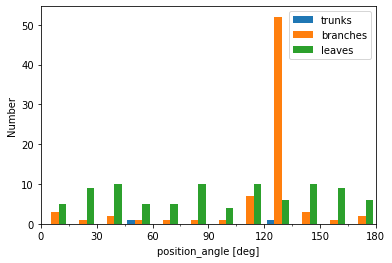

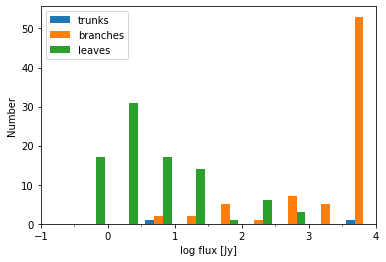

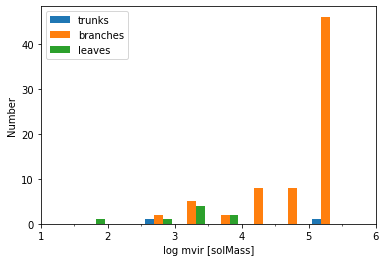

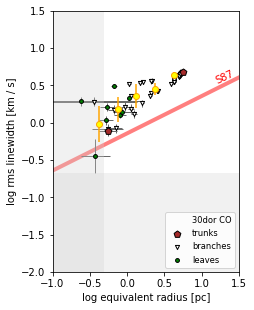

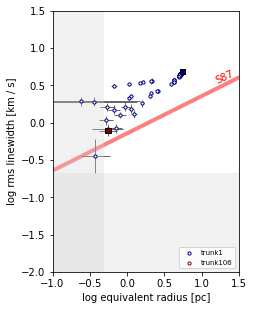

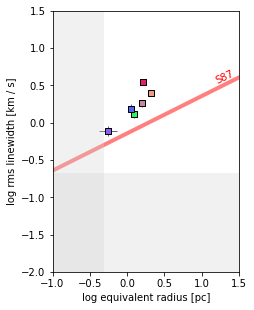

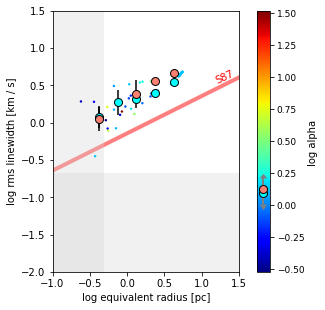

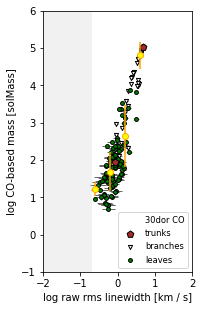

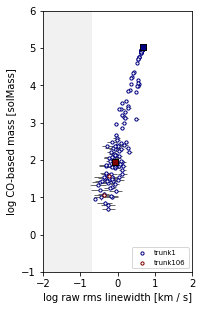

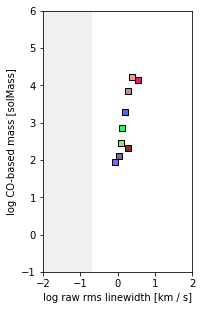

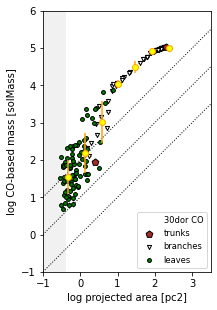

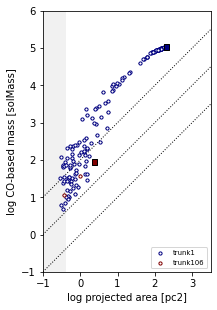

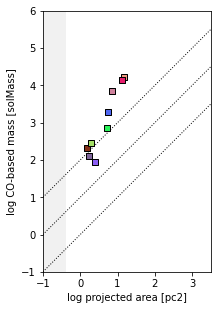

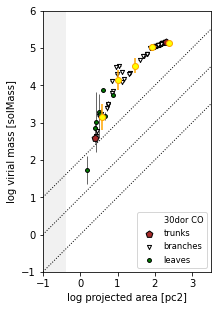

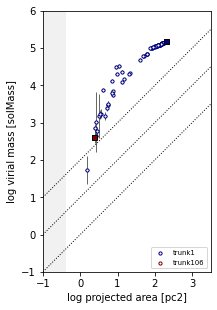

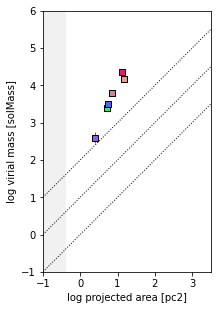

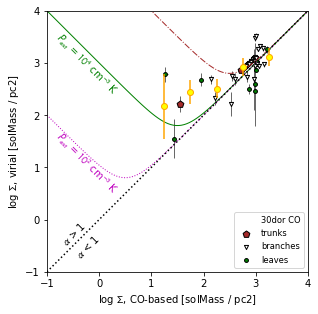

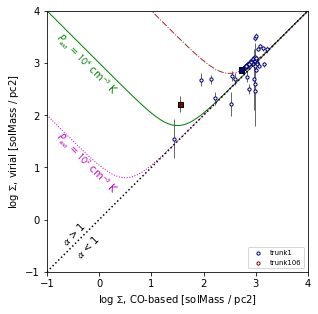

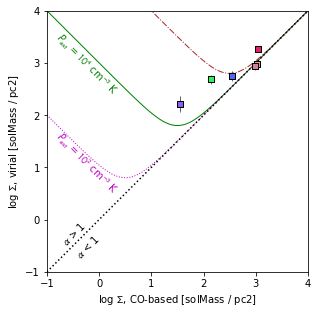

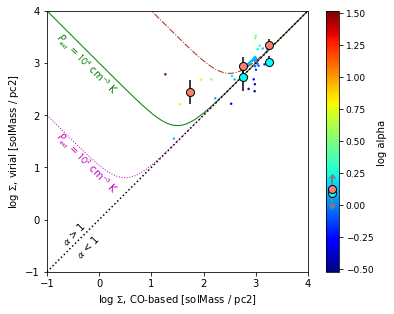

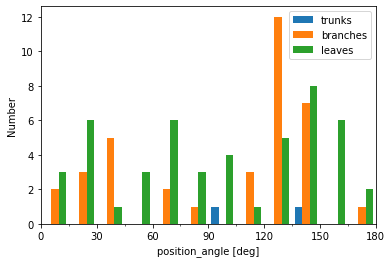

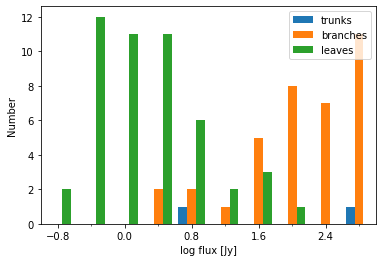

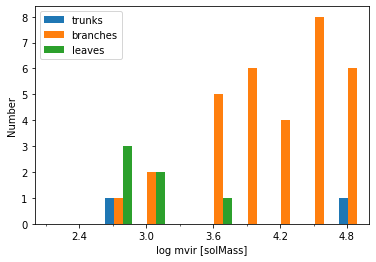

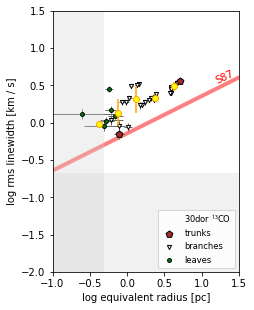

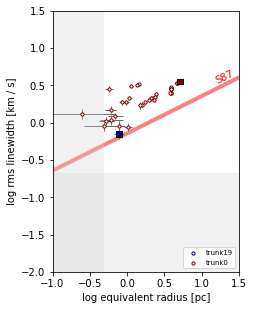

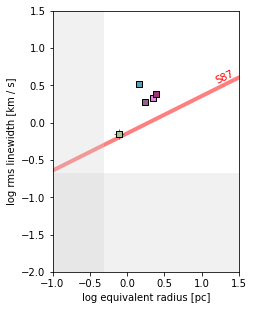

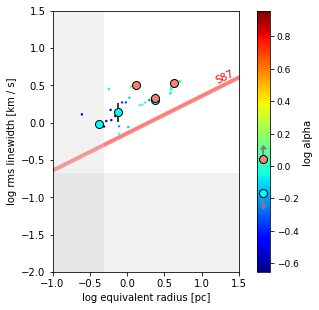

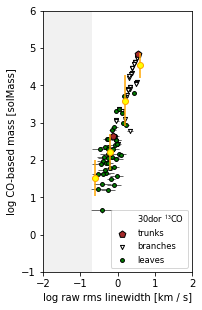

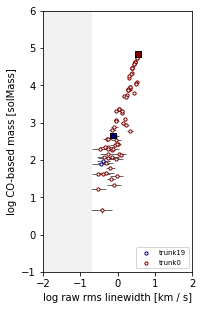

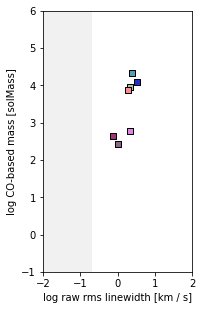

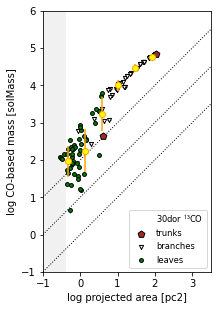

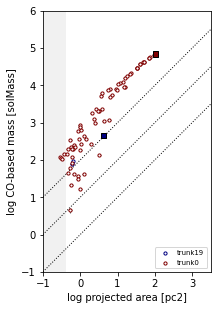

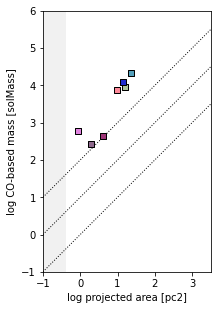

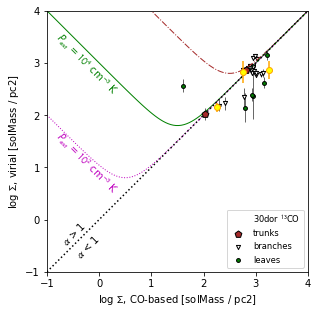

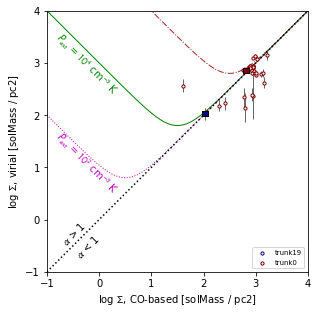

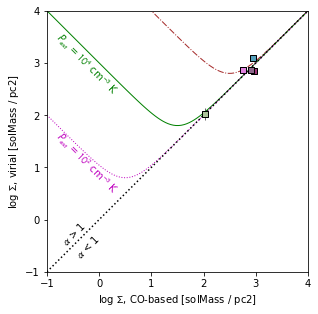

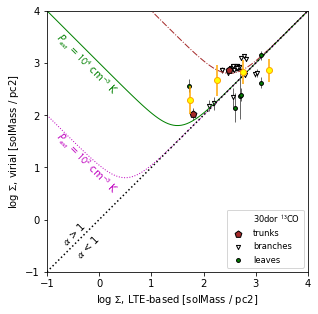

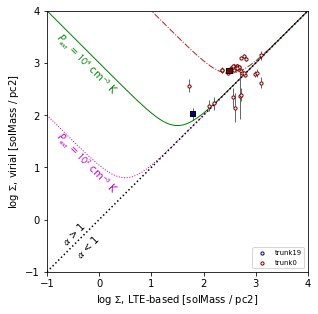

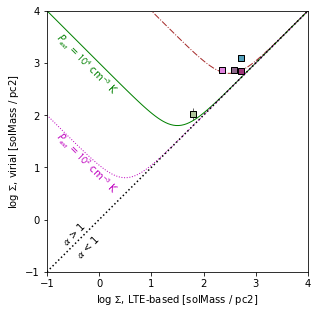

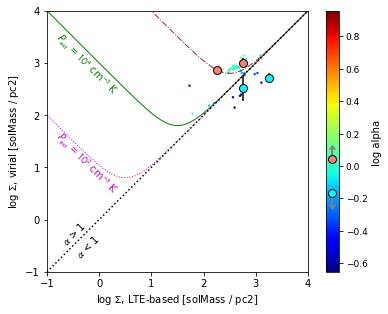

time: 5.87 s (started: 2022-09-27 10:57:15 -07:00)


In [8]:
old_dir = os.getcwd()
os.chdir(dendir)

for i, line in enumerate(['12', '13']):
    catalog = '30dor_'+line+'_full_catalog.txt'
    if line == '12':
        pltprops(catalog, dvkms=0.5, beam=2.5, 
            xplot=['rad_pc_dcon','vrms_k','area_pc2','area_pc2','siglum'],
            yplot=['vrms_k_dcon','mlumco',  'mlumco',    'mvir','sigvir'],
            xlims=[     [-1,1.5],  [-2,2],  [-1,3.5],  [-1,3.5],  [-1,4]],
            ylims=[     [-2,1.5],  [-1,6],    [-1,6],    [-1,6],  [-1,4]],
            pltname=[      'rdv','dvmlum','areamlum',  'areamv',   'bnd'],
            ccode=[         True,   False,     False,     False,    True], 
            colorcodes=['alpha'], nbin=10)
    else:
        pltprops(catalog, dvkms=0.5, beam=2.5, 
            xplot=['rad_pc_dcon','vrms_k','area_pc2',  'siglum','siglte'],
            yplot=['vrms_k_dcon','mlumco',  'mlumco',  'sigvir','sigvir'],
            xlims=[     [-1,1.5],  [-2,2],  [-1,3.5],    [-1,4],  [-1,4]],
            ylims=[     [-2,1.5],  [-1,6],    [-1,6],    [-1,4],  [-1,4]],
            pltname=[      'rdv','dvmlum','areamlum',     'bnd','bndlte'],
            ccode=[         True,   False,     False,     False,    True],
            colorcodes=['alpha'], nbin=10)

os.chdir(old_dir)